# R을 이용한 부동산 실거래 공공데이터 전처리 및 분석
### IQR 분위수에 따른 거래가의 대표값 및 증감률의 변화
-----------------------------------------------------------------------------
## 1.GOAL ##
- 데이터 탐색을 통하여 이상치에 해당하는 데이터와 정상분포에 해당하는 데이터를 비교 분석한다.
- 서울 특별시의 [권역별], [년도별], [분기별], [각 행정구의 년도 / 분기별] 
  실거래가의 변화를 확인하여 패턴이나 특이점을 찾는다.
- 효율적인 데이터 전처리와 성능을 우선하여 코딩을 작성한다.(data.table, pipeline)
- 찾아낸 특이 점이나 패턴을 네이버 부동산 뉴스를 통하여 확인 할 수 있는지 스크롤링 한다.(파이썬을 통한 접근)
- database에 table을 생성하여 연산된 값을 저장한다.

## 2.DATA SET ##
- ****국토해양부 실거래가<http://rtdown.molit.go.kr/download/downloadMainList.do>****
![원본데이터](https://user-images.githubusercontent.com/30791788/34996442-8cbaeb30-fad1-11e7-8cf6-92f4ba13f5f8.PNG "**원본데이터**")
- 원본 데이터는 excel파일로 해당 사이트에서 다운이 가능하며 서울특별시 sheet 만 분석에 사용.
- 2013~2016년까지 48건의 엑셀 파일이 있으며 380311 관측치를 갖는다.
- 아래와 같은 속성값을 갖도록 변형 한다.  
  
## 3.ISSUE ##
- 권역 / 분기 정보 생성(inner join을 통한 권역 정보 생성, 조건문을 통한 분기 정보 생성)
- 전용면적을 계급값(under-60㎡,61-85㎡,86-135㎡,over-135㎡ / 소형, 중형, 대형, 초대형)으로 표현
- 시군구의 row값이 [서울특별시 강남구 개포동]으로 되어 있어 구와 동을 분리하여 각각의 컬럼을 생성해야 한다.
- 거래금액(만원) 컬럼의 row값이 천단위로 쉼표 표시로 인한 type오류.
- 거래금액 만원 단위 -> 억 단위로 변경
- 컬럼 명이 8행에 위치  
- 서울특별시 sheet이지만 중간중간 다른 지역의 정보 값도 내재 되어있다.

## 4.FUNTION Explanation ##
- workYear : 환경에 저장되어 있는 데이터 셋에서 원하는 년도를 분류 한다.
- findGu : 검색 할 구를 선택 하거나 기본 셋팅 되어있는 리스트를 사용 하고 mapping을 위한 데이터프레임을 생성한다.
- pre_apt : ISSUE에 해당하는 문제해결 하고 data.table, pipeline을 사용하여 분석에 맞게 전처리 한다.
 
- - -

#### LIBRARY

In [1]:
library(data.table)
library(DBI)
library(ggplot2)
library(gridExtra)
library(magrittr)
library(readxl)
library(reshape2)
library(RMySQL)
library(timeDate)
library(zoo)
options(warn=-1) 

Warning message:
"package 'gridExtra' was built under R version 3.4.3"
Attaching package: 'reshape2'

The following objects are masked from 'package:data.table':

    dcast, melt

Warning message:
"package 'RMySQL' was built under R version 3.4.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



#### Call Directory

In [2]:
setwd('D:/WorkSpace/R/아파트매매')
dir <- c('D:/WorkSpace/R/아파트매매')

#### workYear

In [3]:
#디렉토리 안의 파일 리스트에서 사용자가 지정한 날짜를 분류하여 목록을 가져오는 함수
#st : 시작 년
#ed : 종료 년  
#미입력 시  리스트를 전부 가져온다.
workYear <- function(st = '', ed = ''){ 
  aptfile <- list.files(dir)   
  if ( st == '' & ed == ''){   #전체 리스트
    return(aptfile)}
  else if (st !='' & ed == '') #시작 년도만 지정
    return(aptfile[between(as.numeric(tstrsplit(aptfile,'년')[[1]]), st, max(as.numeric(tstrsplit(aptfile,'년')[[1]])))])
  else if(st & ed != '')
    return(aptfile[between(as.numeric(tstrsplit(aptfile,'년')[[1]]), st, ed)]) #시작, 마지막년도 지정
}

#### findGu

In [4]:
#검색할 구, 권역 선택 함수
#se : 권역, 선택 할 구, ALL등 사용자 선택 가능하도록 해주는 함수
findGu <- function(se = 'ALL'){
  options(warn=-1) 
  seoul <- list("서울동남" = c("강남구", "강동구", "서초구", "송파구"),         #서울 행정구를 권역별 기준에 따라 리스트 생성
                "서울동북" = c("강북구", "광진구", "노원구", "도봉구", "동대문구", "성동구", "성북구", "중랑구"),
                "서울서남" = c("강서구", "관악구", "구로구", "금천구", "동작구", "양천구", "영등포구"),
                "서울서북" = c("마포구", "서대문구", "은평구"),
                "서울도심" = c("용산구", "종로구", "중구"))
  
  if (se == 'list')          #mapping table 호출시 사용
    return(melt(seoul))
  
  if (!(se %in% c(unlist(seoul), names(seoul), c('ES','EN','SS','SN','SC','ALL','list'))))#리스트에 없는 정보 호출 시 error
    stop('검색 조건을 확인 하세요') 
  
  if (se !='' & !(se %in% c(names(seoul),c('ES','EN','SS','SN','SC','ALL','list'))))#위의 조건문으로 리스트에 있는 입력 값이나 
      return(se)                                                                    #[권역별, 전체]행정구가 아닌 선택한 구 호출 
        
  
  if (se == 'ALL' | se == 'A') se <- c(matrix(unlist(seoul)))                             #권역별 행정구 선택
  else if (se == '서울동남' | se == 'ES') se <-seoul[[1]]
  else if (se == '서울동북' | se == 'EN') se <-seoul[[2]]
  else if (se == '서울서남' | se == 'SS') se <-seoul[[3]]
  else if (se == '서울서북' | se == 'SN') se <-seoul[[4]]
  else if (se == '서울도심' | se == 'SC') se <-seoul[[5]]
  
  return(se)
}


#### pre_apt

In [5]:
#전처리 메인 함수
#work : workYear함수를 통해 구해진 엑셀 파일 리스트
#gu : findGu 함수를 호출 할때 사용 매개변수(검색할 구 or 권역 입력가능)
pre_apt <- function(work,Gu){

  cnt <- 1
  aptBox <- list()
  searchGu <- findGu(Gu)
  mapping <- findGu('list') %>% setnames(.,c('구','권역'))    #권역 정보 join을 위한 데이터 프레임 생성
  
  for (i in work){
    
    ym <- gsub('[년월]','',tstrsplit(i,'_'))                  #해당 년/월 정보 생성
    
    rApt <- read_excel(i, sheet = '서울특별시', skip = 7, col_names = T, col_type = 'guess') %>% as.data.table %>% 
      .[,c(1,3,4,5,6,7,8)] %>% setnames(.,c(1,3,5),c('구동','전용면적','거래금액')) %>% 
      .[, c('구','동') := tstrsplit(구동, ' ', fixed = T, keep = c(2,3))] %>%   #한 컬럼에 명시된 구/동을 각각의 컬럼으로 분리  
      .[구 %in% searchGu] %>%                                                   #필요한 행정구만 분리
      .[, 구동 := NULL] %>% merge(.,mapping, by = '구') %>%                     #join을 통해 쉽게 권역정보 생성
      .[, 거래금액 := gsub(',','', .$거래금액)] %>%  
      .[, '년' := ym[1]] %>% 
      .[, '월' := ym[2]] %>% 
      .[, '분기' := paste0(년,ifelse(between(as.numeric(월),1,3),'Q1', 
                                  ifelse(between(as.numeric(월),4,6),'Q2',
                                         ifelse(between(as.numeric(월),7,9),'Q3', 'Q4'))))] %>%       #분기 정보 분할 생성
      .[, '전용면적' := ifelse(as.numeric(전용면적) <= 60,'under-60㎡',
                               ifelse(between(as.numeric(전용면적), 61, 85, incbounds=TRUE),'61-85㎡', 
                                      ifelse(between(as.numeric(전용면적), 86, 135, incbounds=TRUE),'86-135㎡','over-135㎡')))] %>% 
                                       #전용면적으로 소,중,대,특대 사이즈로 분할 생성 / 기준 국토교통부 부동산 평가과
      
      .[,c(names(.)[!names(.) %in% c('단지명','거래금액','건축년도')]) := lapply(.SD, as.factor), 
                        .SDcols = c(names(.)[!names(.) %in% c('단지명','거래금액','건축년도')])] %>%           
                         #단지명, 거래금액, 건축년도를 제외하고 팩터타입으로 변경, 추후 임포트 테이블 스키마에 따른 변경 가능.
      .[,거래금액 := as.numeric(거래금액) / 10000] %>%   #거래금액 억단위 변환                        
    
      .[,c(9,12,10,11,1,8,2,3,6,4,7,5)]   

        aptBox[[cnt]] <- rApt
    cnt <- cnt + 1
    
  }
  
  apt1 <- rbindlist(aptBox) 
  return(apt1)
}

#### input arg 

In [6]:
i_start <- ''                  #검색 시작날짜 설정
i_end <- ''                    #검색 종료 날짜 설정
i_area <- 'ALL'                #검색 할 지역 설정 기본 셋팅은 전체 행정구이다. 권역별, 사용자가 원하는 구 입력 가능.


apt_process <- function(i_start,i_end,i_area){
      c_work <- workYear(i_start,i_end)
      result_table <- pre_apt(c_work,i_area)
return(result_table)
}

#### process 

In [7]:
system.time(preApt <- apt_process(i_start,i_end,i_area))

   user  system elapsed 
  14.31    1.03   16.64 

### ◎전처리 후 데이터 확인◎

In [8]:
str(preApt)

Classes 'data.table' and 'data.frame':	380311 obs. of  12 variables:
 $ 권역    : Factor w/ 5 levels "서울도심","서울동남",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ 분기    : Factor w/ 16 levels "2013Q1","2013Q2",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ 년      : Factor w/ 4 levels "2013","2014",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ 월      : Factor w/ 12 levels "01","02","03",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ 구      : Factor w/ 25 levels "강남구","강동구",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ 동      : Factor w/ 326 levels "가락동","가산동",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ 단지명  : chr  "개포자이(12-2)" "개포주공 1단지" "개포주공 1단지" "개포주공 1단지" ...
 $ 전용면적: Factor w/ 4 levels "61-85㎡","86-135㎡",..: 2 4 4 4 4 4 4 4 4 4 ...
 $ 층      : Factor w/ 73 levels "1","10","11",..: 33 1 37 1 37 23 37 37 37 33 ...
 $ 계약일  : Factor w/ 6 levels "1~10","11~20",..: 3 1 2 3 2 2 2 3 3 2 ...
 $ 건축년도: chr  "2004" "1982" "1982" "1982" ...
 $ 거래금액: num  8.9 4.94 5.05 5.4 5.04 5.9 6 6.3 6.45 6 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [9]:
rbindlist(list(head(preApt),tail(preApt)))
print(paste('결측치 : ', sum(is.na(preApt))))

권역,분기,년,월,구,동,단지명,전용면적,층,계약일,건축년도,거래금액
서울동남,2013Q1,2013,01,강남구,개포동,개포자이(12-2),86-135㎡,4,21~31,2004,8.90
서울동남,2013Q1,2013,01,강남구,개포동,개포주공 1단지,under-60㎡,1,1~10,1982,4.94
서울동남,2013Q1,2013,01,강남구,개포동,개포주공 1단지,under-60㎡,5,11~20,1982,5.05
서울동남,2013Q1,2013,01,강남구,개포동,개포주공 1단지,under-60㎡,1,21~31,1982,5.40
서울동남,2013Q1,2013,01,강남구,개포동,개포주공 1단지,under-60㎡,5,11~20,1982,5.04
서울동남,2013Q1,2013,01,강남구,개포동,개포주공 1단지,under-60㎡,3,11~20,1982,5.90
서울동북,2016Q4,2016,12,중랑구,중화동,동양엔파트,61-85㎡,13,1~10,2010,3.98
서울동북,2016Q4,2016,12,중랑구,중화동,미영리치타운,61-85㎡,7,21~31,2007,3.70
서울동북,2016Q4,2016,12,중랑구,중화동,한솔e(B동),under-60㎡,7,1~10,2004,1.65
서울동북,2016Q4,2016,12,중랑구,중화동,한신1차,under-60㎡,14,1~10,1997,3.20


[1] "결측치 :  0"


- - - 
 2013년1분기 부터 2016년 4분기까지 데이터(380311 obs, 12 variables)로 전처리 되었다. 결측치는 없으며 전체 원천데이터를 원하는 방향(권역, 분기, 년, 월, 구, 동, 단지명, 전용면적(㎡), 층, 계약일, 건축년도, 거래금액(억)으로 완성되었으며 전체 처리시간은 약17초이다.
 - - - 

### ◎데이터 탐색◎

In [10]:
summary(preApt)

       권역             분기           년               월        
 서울도심: 14551   2015Q1 : 34765   2013: 67701   10     : 38990  
 서울동남: 86584   2016Q2 : 34531   2014: 85311   03     : 38804  
 서울동북:129287   2016Q3 : 34206   2015:119820   09     : 38168  
 서울서남:112746   2015Q2 : 32769   2016:107479   06     : 34428  
 서울서북: 37143   2015Q3 : 29577                 04     : 34311  
                   2014Q3 : 25135                 08     : 33925  
                   (Other):189328                 (Other):161685  
       구               동            단지명                전용면적     
 노원구 : 37929   상계동 : 15124   Length:380311      61-85㎡   :166948  
 강남구 : 24301   중계동 :  8411   Class :character   86-135㎡  : 53943  
 송파구 : 24300   신정동 :  8144   Mode  :character   over-135㎡: 16537  
 강서구 : 24078   창동   :  7467                      under-60㎡:142883  
 성북구 : 19947   구로동 :  7447                                         
 강동구 : 19911   봉천동 :  6938                                         
 (Other):229845   (O

- - - 
- 해마다 약 2만건 씩 상승하고 있으나 2016년에는 거래 건수가 줄었다.
- 중,소 형 평수 위주로 거래가 많이 되었다.
- 거래금액은 평균 4억8천이며 중앙값은 4억이다. 
- 10월, 3월, 9월에 거래건수가 가장 많다.
- 노원구 상계동이 큰 차이로 거래량이 많다.
- 계약일은 부동산 거래 심리에 큰 영향은 없어 보인다.
- 5~7층은 대체적으로 중.저층으로 분류되는데 가장 많은 거래가 있었다.

 먼저 평균이 4억 8천 중앙값이 4억이라는 요약 정보가 있지만 거래금액의 범위가 700만 ~ 79억으로 차이가 매우 크다.-각 행정구, 각 동에 대한 평당가 편차가 있을 것이고, 단지마다 거래금액 차이가 있을 수 있다.- 
또한 아파트 매매 실거래가 분석에 부적합데이터가 존재 할 것이라 예상 되여(min값 700만원) 정확한 평균값이라 기대하기 어렵다.
- - - 

### 1)OUTLIER 분포 확인
###### 2013~2016 전체 거래금액 대상

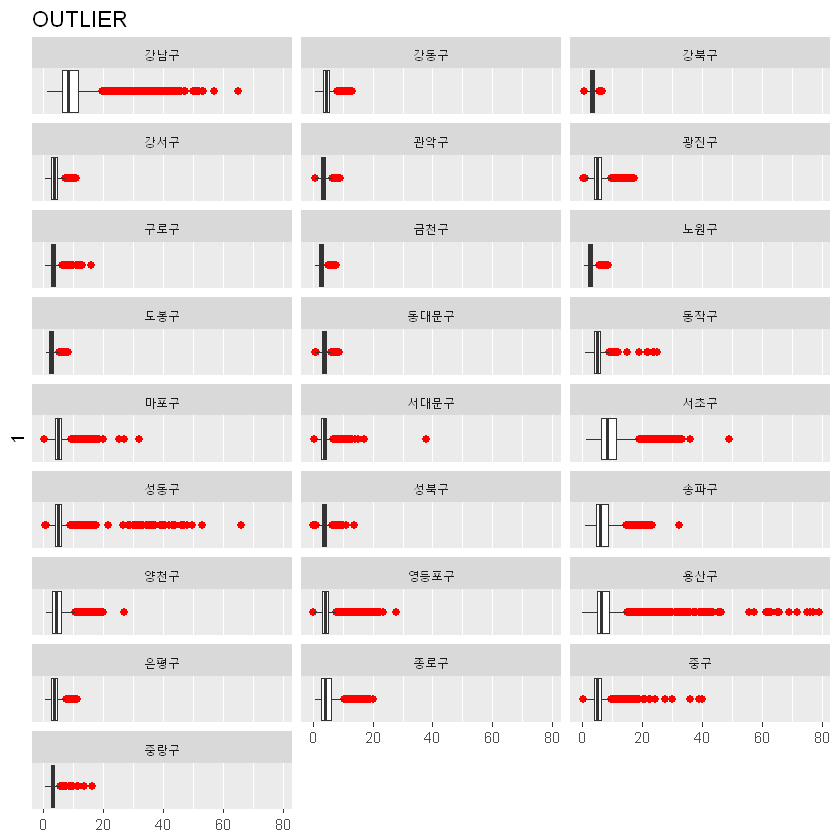

In [11]:
ggplot(preApt, aes(x = 1, y = (거래금액))) + 
  geom_boxplot(width=0.1, outlier.size=2, outlier.shape=16, outlier.colour="red") + 
  scale_x_continuous(breaks = NULL) + 
  theme(axis.title.x = element_blank()) + 
  facet_wrap(~구,scale='free_y', ncol=3)+
  coord_flip() +
  ggtitle("OUTLIER")

- - - 
* 서울의 각 행정구 중에서 눈에 띄게 OUTLIER를 가지고 있는 지역은 용산구, 강남구, 성동구이다. 
* 40억 이상을 호가하는 아파트 단지가 있고 평균에 상당한 영향을 미칠 것이라 예상된다. 
* 특정한 구를 제외하면 전체적으로 10억미만에서 금액이 형성되어있고  10억의 절반에서 왼쪽으로 치우쳐있음을 확인 할 수 있다. 
* 극단치를 띄고 있는 데이터들은 어떤 데이터인지 확인해 볼 필요가 있다.
- - - 

### 2)첨도 왜도
###### 2013~2016 구별 전체 거래금액 대상

- 각 행정구 마다 첨도 왜도값을 구해 평균과 얼마나 떨어 져있으며, 분포가 치우쳐 있는지 확인한다.

In [12]:
#구 별로 그룹을 나누어 왜도, 첨도 값을 계산 후 조인 한다.
skku <- merge(preApt[, .(sk = skewness(거래금액)), by = c('구')],preApt[, .(ku = kurtosis(거래금액)), by = c('구')],
              by = c('구'))

In [13]:
skku[order(-ku)]

구,sk,ku
성동구,8.13459802,90.0829670
서대문구,3.47142215,62.3556755
용산구,4.39408497,29.0236873
중구,3.28687515,24.3570072
마포구,2.39304550,8.7814896
강남구,2.09079166,8.2899641
영등포구,2.02141139,7.2494391
동작구,0.88919078,6.4980638
중랑구,0.99250112,5.7229200
구로구,1.04103993,3.8994449


--- 
BOXPLOT에서 확인 할 수 있듯이 **성동구, 서대문구 용산구 중구 등이 평균가 보다 멀리 떨어진 거래량이 많았음을 확인 할 수 있다.**
대부분 양의 왜도값을 가지고 있어 평균보다 중앙값이 작다. 
실거래의 분포는 여러 요인에 의해 분포가 다양하게 형성되어있음을 예상 할 수 있다.  
다음 분석에서는 **년, 구, 전용면적별로 그룹화하여 보다 분포에 맞는 대표값을 찾아 분석 하도록 한다.**
-- - 

## 3)이상치, 극단치에 대한 사실 분석
#### 데이터 셋 분류 년도 / 구 /  전용면적(60이하, 61~85, 86~135, 135이상) 각 분류에 맞게 IQR값을 구한다.
- 이상치와 극이상치 데이터를 비교 분석한다.

### Inter Quartile range (IQR)
![iqr](https://user-images.githubusercontent.com/30791788/36073087-d183f274-0f22-11e8-89c1-cb0113f8d1ad.JPG)
- - - 
- 사분위수 Q3에서 Q1값을 뺀 값을 의미한다. 
whisker에 해당하는 값까지는 이상치로 분류하지 않는다. 보통 그 값은 Q3 + IQR * (1.5 or 3), Q1 - IQR * (1.5 or 3)로 범위를 정한다.
- 정확한 분류를 위해 년, 구, 전용면적 단위로 해당 값을 찾아 비교한다. 
- 인정 범위에 해당 하지 않는 실거래 데이터 값을 찾아 분석한다.
- - - 

In [14]:
#데이터를 입력 받아 입력받은 배수 만큼 IQR을 구하여 하나의 data.table로 만드는 함수
#dt : 입력 데이터
#prd : 배수(1.5 or 3)
#... : 사분위수를 구할 그룹

preApt_IQR <- function(dt, prd, ...){
  sel <- c(...) #사분위수를 구할 그룹
  QQ  <- dt[, .(QQ = quantile(거래금액)[c(2,4)]), by = sel] #사분위수에서 Q1,Q3정보만 추출
  IQR <- dt[, .(IQR = IQR(거래금액) * prd), by = sel]       #해당 그룹의 IQR값을 구하여 prd값을 곱한다.
  mergTable <- merge(QQ,IQR, by = sel)                      #쉬운 연산을 위하여 QQ & IQR table 조인
  QQIQR <- mergTable[,ifelse(QQ == min(QQ), QQ - IQR, QQ + IQR),by = sel]#QQ 테이블(Q1,Q2)에서 최소값이면 계산된 IQR빼고 아니면 더한다.: 해당그룹에서 Q1과 Q3값만 있기 때문.
  
  return(merge(merge(dt, QQIQR[,.(IQRMIN = min(V1)),by = sel], by = sel),
               QQIQR[,.(IQRMAX = max(V1)),by = sel], by = sel))  #입력 받은 데이터 셋에 계산된 이상치 범위 값(min,max) 입력
}


### ⊙IQR범위를 적용한 테이블 생성⊙
- 년, 구, 전용면적별로 계산된 IQR계산값을 효율적으로 계산하기위한 작업
- 년, 구, 전용면적별 IQRMIN과 IQRMAX값을 구하여 전처리 된 테이블(preApt)에 조인 시킨다.
- IQR * 1.5배 IQRMIN,IQRMAX
- IQR * 3배 IQRMIN3, IQRMAX3

In [15]:
#preApt_IQR로 정의 된 함수를 이용하여 각 배수 마다 1.5배 3배를 적용한 테이블을 하나의 테이블로 합치는 작업
IQR <-  preApt_IQR(preApt, 1.5,'년','구','전용면적')  %>% 
        .[,c('IQRMIN3','IQRMAX3') := preApt_IQR(preApt, 3,'년','구','전용면적')[,c('IQRMIN','IQRMAX')]]


In [16]:
head(IQR,5)   #IQR*1.5의 값과 IQR * 3의 값을 (년, 구, 전용면적)그룹으로 묶어 계산한 값을 하나로 합친 테이블 생성.

년,구,전용면적,권역,분기,월,동,단지명,층,계약일,건축년도,거래금액,IQRMIN,IQRMAX,IQRMIN3,IQRMAX3
2013,강남구,61-85㎡,서울동남,2013Q1,01,개포동,개포주공 5단지,8,21~31,1983,6.00,2.725,12.525,-0.95,16.2
2013,강남구,61-85㎡,서울동남,2013Q1,01,개포동,개포주공 6단지,6,1~10,1983,6.75,2.725,12.525,-0.95,16.2
2013,강남구,61-85㎡,서울동남,2013Q1,01,개포동,개포주공 6단지,13,21~31,1983,7.15,2.725,12.525,-0.95,16.2
2013,강남구,61-85㎡,서울동남,2013Q1,01,개포동,개포주공 6단지,6,21~31,1983,8.00,2.725,12.525,-0.95,16.2
2013,강남구,61-85㎡,서울동남,2013Q1,01,개포동,개포주공 7단지,10,21~31,1983,7.10,2.725,12.525,-0.95,16.2


#### ⊙IQR * 1.5배 사이에 있는 데이터 값,  해당 하는 단지 확인(이상치 데이터)⊙

In [17]:
#이상치에 해당하는 데이터 추출
outlierset1.5 <- IQR[(거래금액 <= IQRMIN & 거래금액 >= IQRMIN3) | (거래금액 >= IQRMAX & 거래금액 <= IQRMAX3)] 

In [18]:
#년도별 이상치 건수 확인
outlierset1.5[,.N, by = c('년')]

년,N
2013,917
2014,1176
2015,1656
2016,1276


In [19]:
cat(paste("*LIF + UIF 건수 : ", length(outlierset1.5$거래금액)))
sort(table(outlierset1.5$구), decreasing = T)
cat('*총 거래량 대비 이상치 비율')
sort(table(outlierset1.5$구) / table(preApt$구) * 100, decreasing = T)

*LIF + UIF 건수 :  5025


  서초구   성동구     중구 영등포구   강서구   금천구   광진구   노원구 
     750      388      380      306      296      287      256      251 
  동작구 동대문구   구로구   성북구   마포구   강남구   강동구   용산구 
     240      221      220      208      172      167      150      145 
  강북구   도봉구 서대문구   중랑구   관악구   은평구   송파구   종로구 
     126      104      104       92       84       27       23       19 
  양천구 
       9 

*총 거래량 대비 이상치 비율


      중구     금천구     서초구     광진구     성동구     용산구   영등포구 
8.21621622 4.42355117 4.15006640 3.38177015 2.78455576 2.05557131 1.86870229 
    강북구   동대문구     동작구     마포구     강서구     구로구     성북구 
1.73148275 1.65369650 1.54261473 1.23112161 1.22933798 1.12044818 1.04276332 
  서대문구     강동구     중랑구     관악구     강남구     노원구     종로구 
0.98438239 0.75335242 0.73723856 0.69278351 0.68721452 0.66176277 0.66155989 
    도봉구     은평구     송파구     양천구 
0.61952701 0.21416673 0.09465021 0.04868286 

###### IQR에 1.5배를 하여 계산한 각 행정구마다 이상치에 해당하는 건수이다. 각 행정구마다 총 거래 건수에서의 비율을 같이 확인한다.

In [20]:
upiF <- outlierset1.5[거래금액 >= IQRMAX, .N, by = c('구','단지명')][order(-N)] 
print(paste("UIF 건수 : ", sum(upiF$N)))
head(upiF,5)

[1] "UIF 건수 :  3932"


구,단지명,N
서초구,래미안퍼스티지,277
서초구,반포자이,276
금천구,남서울힐스테이트,232
성동구,래미안 옥수 리버젠,169
서초구,반포 주공1단지,132


In [21]:
downiF <- outlierset1.5[거래금액 <= IQRMIN, .N, by = c('구','단지명')][order(-N)]
print(paste("LIF 건수 : ", sum(downiF$N)))
head(downiF,5)  

[1] "LIF 건수 :  1093"


구,단지명,N
성북구,대광,59
광진구,광진코지웰,41
성동구,삼성홈타운,39
동작구,씨티아모리움,33
마포구,비체힐리버뷰,33


###### 첨도 왜도값의 큰 치우침을 보이는 행정구의 이상치에 해당하는 데이터는 몇몇 단지들이 차지하고 있음 알 수 있다.

#### ⊙IQR * 3배 사이에 있는 데이터 값,  해당 하는 단지 확인(극 이상치)⊙

In [22]:
# 극 이상치 데이터 추출
outlierset3 <- IQR[거래금액 <= IQRMIN3 | 거래금액 >= IQRMAX3] 

In [23]:
#년도별 이상치 건수 확인
outlierset3[,.N, by = c('년')] 

년,N
2013,51
2014,65
2015,73
2016,56


In [24]:
cat(paste("*LIF + UIF 건수 : ", length(outlierset3$거래금액)))
sort(table(outlierset3$구), decreasing = T)
cat('*총 거래량 대비 이상치 비율')
sort(table(outlierset3$구) / table(preApt$구) * 100, decreasing = T)

*LIF + UIF 건수 :  245


  용산구     중구   성동구   강남구   마포구   성북구 영등포구   강서구 
      35       33       23       20       20       20       17       16 
서대문구   강북구   광진구   동작구   서초구   관악구   구로구   금천구 
      12       11        8        7        5        4        4        4 
  종로구   중랑구 동대문구   송파구   강동구   노원구   도봉구   양천구 
       2        2        1        1        0        0        0        0 
  은평구 
       0 

*총 거래량 대비 이상치 비율


       중구      용산구      성동구      강북구      마포구    서대문구 
0.713513514 0.496172384 0.165063873 0.151161193 0.143153675 0.113582584 
     광진구    영등포구      성북구      강남구      종로구      강서구 
0.105680317 0.103816794 0.100265704 0.082301140 0.069637883 0.066450702 
     금천구      동작구      관악구      서초구      구로구      중랑구 
0.061652281 0.044992930 0.032989691 0.027667109 0.020371785 0.016026925 
   동대문구      송파구      강동구      노원구      도봉구      양천구 
0.007482790 0.004115226 0.000000000 0.000000000 0.000000000 0.000000000 
     은평구 
0.000000000 

In [25]:
upoF <- outlierset3[거래금액 >= IQRMAX, .N, by = c('구','단지명')][order(-N)]
print(paste("UOF 건수 : ", sum(upoF$N)))
head(upoF,5)  

[1] "UOF 건수 :  193"


구,단지명,N
용산구,한남더힐,22
성동구,래미안 옥수 리버젠,17
영등포구,삼부,15
용산구,래미안첼리투스아파트,12
성북구,코업스타클래스,9


In [26]:
downoF <- outlierset3[거래금액 <= IQRMIN, .N, by = c('구','단지명')][order(-N)]
print(paste("LIF 건수 : ", sum(downoF$N)))
head(downoF,5) 

[1] "LIF 건수 :  52"


구,단지명,N
마포구,코오롱,4
성북구,대광,4
중구,(372-66),4
강서구,강서뉴,3
강서구,정원,3


### 4)거래금액 > IQRMAX : 구평균, 이상치 평균, 극이상치평균, 건수,  차이 비교

In [58]:
meanif <- merge(IQR[, .(구평균 = mean(거래금액)), by = '구'], IQR[거래금액 >= IQRMAX, list(이상치건수1.5 = length(거래금액), 이상치평균1.5 = mean(거래금액)), by = '구'],all.x = T, by = '구')
meanof <- IQR[거래금액 >= IQRMAX3, list(이상치건수3 = length(거래금액), 이상치평균3 = mean(거래금액)), by = '구']

In [61]:
cptable <- merge(meanif,meanof,all.x=T,by = '구')  %>% .[,c('Diff1.5','Diff3','Diff_이상치') := list(이상치평균1.5 - 구평균,이상치평균3 - 구평균,이상치평균3 - 이상치평균1.5)]

cptable[order(-Diff_이상치)]


구,구평균,이상치건수1.5,이상치평균1.5,이상치건수3,이상치평균3,Diff1.5,Diff3,Diff_이상치
용산구,8.181540,177,25.066018,35,44.485429,16.884478,36.303888,19.419410
동작구,5.031661,149,7.410872,7,22.970757,2.379211,17.939096,15.559885
강남구,9.427761,187,33.546783,20,48.727500,24.119022,39.299739,15.180717
송파구,6.802916,24,17.558179,1,32.500000,10.755264,25.697084,14.941821
성동구,5.263481,327,9.575385,23,21.106522,4.311904,15.843041,11.531137
서대문구,3.856787,95,9.004518,12,16.892233,5.147731,13.035447,7.887715
서초구,9.458217,753,15.824745,5,23.408000,6.366528,13.949783,7.583255
중구,5.543990,134,9.939159,19,17.320689,4.395169,11.776700,7.381531
강서구,3.699352,281,6.261742,2,10.762000,2.562390,7.062648,4.500258
종로구,4.955020,16,14.087500,2,18.500000,9.132480,13.544980,4.412500


In [62]:
cp_sort_diff <- melt.data.table(cptable, "구", c("구평균", "이상치평균1.5","이상치평균3","Diff_이상치"))

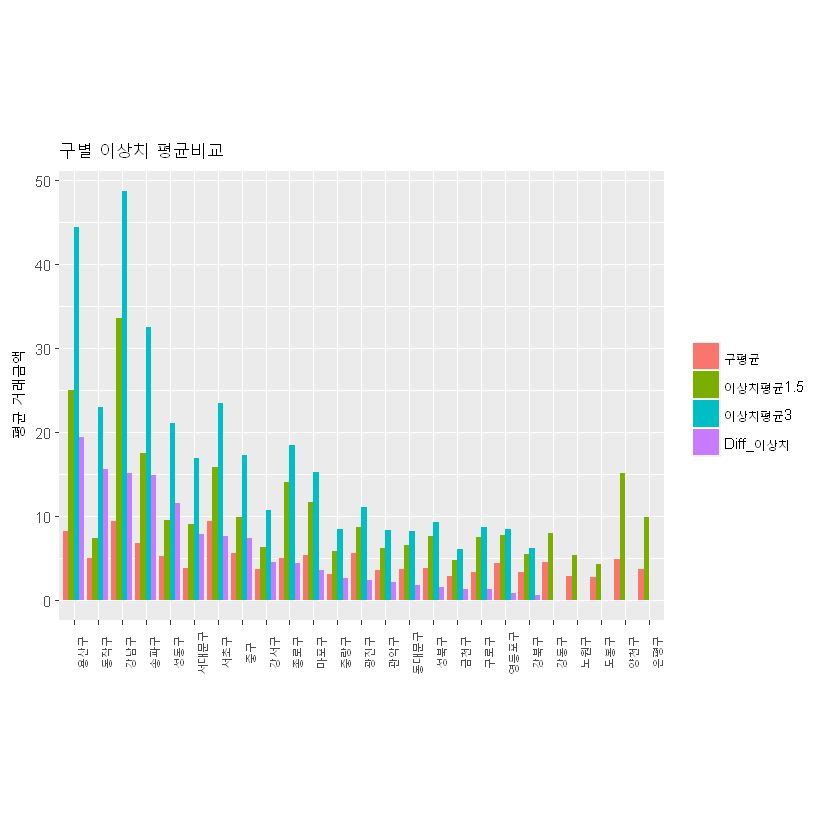

In [64]:
cp_sort_diff[,.SD
    ][, val := value[variable == 'Diff_이상치'], "구"
    ][order(-val,구)
    ][, 구 :=factor(구, ordered = T, levels = unique(구))
    ][, variable := factor(variable)
    ][, ggplot(.SD, aes(x = 구, y = value, fill = variable)) + 
        geom_bar(stat = 'identity', position = position_dodge()) + 
        theme(axis.text.x=element_text(angle=90)) + 
        labs(title = "구별 이상치 평균비교", x='',y='평균 거래금액') +
        guides(fill=guide_legend(title=NULL))+
        coord_fixed(ratio = 0.35)
    ]

#### 대표값 결정 - 이상치, 극이상치 비교 
 각 구평균과의 차이는 1억에서 많게는 36억까지 편차가 있는 실거래가 분포를 형성하고 있다. 
거래건수와 거래금액의 평균으로 보면 **U(IF,OF) 값들이 L(IF,OF)보다 평균에 영향을 더 주는 것으로 확인 된다.** 
첨도 왜도 값으로 치우침이 클거라고 예상된 구들은 (성동구, 서대문구, 용산구, 중구, 마포구, 강남구, 영등포구, 동작구, 중랑구, 구로구, 
종로구, 서초구, 광진구) 이고 실제로 이상치 차이값으로 정렬을 했을때 상위에 위치해있다. 

 **UIF,UOF 거래값을 갖는 정보는 각지역마다의 랜드마크단지로 판단된다.** 
 **LIF,LOF 값을 갖는 정보는 도시형 생활 주택(아파트)로 파악되며 경매로 인한 이상치를 갖는 정보로 보인다.** 
 박스 플롯에서 보였던 극단 이상치(UOF)값은 그에 해당하는 몇몇 단지들의 분포들 때문이라고 판단 되여 제외할 수 있는 값이라 결정하기 어렵다. 그러나 상당한 건수와 큰 거래금액의 단위는 무시하기 할 수 없기때문에 심각하게 낮은 금액은 제외하고 추후 분석의 **대표값을 기하 평균으로 하여 편중을 줄이기로 한다.**
 - - - 

In [32]:
quantile(IQR[거래금액 <= 1]$거래금액) # 1억이하의 거래의 사분위수 추출

0%  25%  50%  75% 100% 
0.07 0.85 0.95 0.99 1.00

In [33]:
IQR <- IQR[!거래금액 <= 0.7 ] #1억미만 매매 거래가 확인 결과 8천만원까지는 정상적인 거래가가 있었으나 그 이하의 거래를 매매가라고 보기는 어려워 제외한다.

### 5). 분기별 이상치 분포에 따른 증감률 비교 및 부동산 대책 시기 확인
- 분기별 표준편차, 평균, 중앙값, 건수, 거래총합, 전 분기 대비 증감율을 구한다.
- 각 속성별로 scale을 적용하여 다차원 비교가 가능하도록 정규화한다. scale = 편차 / 표준편차
- 데이터 셋을 normal, outliers1.5, outliers3 으로 분류하여 비교 분석한다.
- 부동산 대책 시행이 분류된 데이터 셋에 영향이 있었는지 확인한다.

#### 2013~2016부동산 대책
![default](https://user-images.githubusercontent.com/30791788/36348704-b1a334b0-146d-11e8-802f-c3043f7da75f.jpg)


In [34]:
#부동산 대책이 있었던 분기를 1로 없었던 분기를 0으로 하여 그래프에 표현하도록 객체 생성.
pol <- data.table("year" = c(2013,2014,2015,2016),"1Q" = c(0,1,1,0), "2Q" = c(1,0,1,1),
                  "3Q" = c(1,1,1,1), "4Q" = c(1,1,0,0))

cn <- which(as.logical(cbind(pol[1,-1],pol[2,-1],pol[3,-1],pol[4,-1])))

In [35]:
#데이터의 분기 or 년도별 기술통계를 구하는 함수
#yq : 년도, 분기 선택가능하다. 
descstats <- function(cptable, yq = '분기'){
 
  res <- list()
  
  stats <- cptable[, .("표준편차" = sqrt(sum((거래금액 - exp(mean(log(거래금액))))^2) / (length(거래금액) - 1)), #기하평균 표준편차
                       "평균" = exp(mean(log(거래금액))),  #기하평균
                       "중앙값" = median(거래금액),
                       "건수" = .N,
                       "총합" = sum(거래금액)), by = yq] %>% .[order(.[,1])] %>% 
    .[, paste(names(.)[-1],'증감률', sep = '_') := lapply(.SD, function(x){ c(0,diff(x) / x[-length(x)] * 100) }), .SDcols = 표준편차:총합]
                                                    #바로 전 (분기 or 년)값 대비 증감률을 구한다.
  cdt <- copy(stats) %>%  
    .[, names(.)[-1] := lapply(.SD, scale), .SDcols = 표준편차:총합_증감률]  #다차원 값의 비교를 위해 스케일을 적용한다.
  
  
  res[[1]] <- stats    #scale 적용전 값, database에 저장할 데이터
  res[[2]] <- cdt      #scale 적용 값, 그래프 분석에 활용할 데이터
  return(res)
}

In [36]:
#subset - 일반적인 데이터 값, IF, OF 데이터 분할 
normaldt <- IQR[!거래금액 <= IQRMIN & !거래금액 >= IQRMAX]
outlierset1.5 <- IQR[(거래금액 <= IQRMIN & 거래금액 >= IQRMIN3) | (거래금액 >= IQRMAX & 거래금액 <= IQRMAX3)]
outlierset3 <- IQR[거래금액 <= IQRMIN3 | 거래금액 >= IQRMAX3]

#descstats 함수 적용.
normaltrade <- descstats(normaldt)
outtrade1.5 <- descstats(outlierset1.5)
outtrade3 <- descstats(outlierset3)

In [37]:
normaltrade

분기,표준편차,평균,중앙값,건수,총합,표준편차_증감률,평균_증감률,중앙값_증감률,건수_증감률,총합_증감률
2013Q1,3.149121,3.854737,3.650,14137,64274.61,0.0000000,0.00000000,0.0000000,0.000000,0.000000
2013Q2,2.935797,3.736037,3.600,17809,77504.11,-6.7740908,-3.07932830,-1.3698630,25.974393,20.582764
2013Q3,2.629893,3.574049,3.470,15606,63755.96,-10.4197849,-4.33582363,-3.6111111,-12.370150,-17.738603
2013Q4,2.854782,3.833667,3.720,19179,84898.36,8.5512598,7.26397214,7.2046110,22.895040,33.161450
2014Q1,3.026295,3.879266,3.750,23746,106932.97,6.0079012,1.18942580,0.8064516,23.812503,25.954104
2014Q2,2.895061,3.795065,3.700,15316,67271.40,-4.3364473,-2.17054684,-1.3333333,-35.500716,-37.090119
2014Q3,3.026229,3.917656,3.790,24778,113049.36,4.5307486,3.23028808,2.4324324,61.778532,68.049646
2014Q4,2.972121,3.830675,3.750,20226,90151.84,-1.7879559,-2.22024205,-1.0554090,-18.371136,-20.254446
2015Q1,2.819825,3.934618,3.850,34414,154869.64,-5.1241693,2.71344719,2.6666667,70.147335,71.787562
2015Q2,2.967229,4.055160,3.975,32332,150809.98,5.2274319,3.06363145,3.2467532,-6.049863,-2.621344


### ⊙각 분포, 분기별 [표준편차, 평균, 건수, 총합] 그래프 ⊙

In [38]:
#그래프안에 선택한 값을 표현하기 위해 melt 한다.
normal <- melt(normaltrade[[2]][order(분기)], id.vars = '분기', measure.vars = c(names(normaltrade[[2]])[c(2,3,5,6)]))
out1.5 <- melt(outtrade1.5[[2]][order(분기)], id.vars = '분기', measure.vars = c(names(outtrade1.5[[2]])[c(2,3,5,6)]))
out3 <- melt(outtrade3[[2]][order(분기)], id.vars = '분기', measure.vars = c(names(outtrade3[[2]])[c(2,3,5,6)]))

In [39]:
p1 <- ggplot(normal,aes(x=분기, y=value, colour = variable,  group = variable)) +
  geom_line(size = .8) +
  theme(axis.text.x=element_text(angle=90))+
  geom_vline(xintercept = c(cn),linetype="dashed", alpha = .5) +
  labs(x='',y='') +
  guides(color=guide_legend(title="NORMAL"))
p2 <- ggplot(out1.5,aes(x=분기, y=value, colour = variable,  group = variable)) +
  geom_line(size = .8) +
  theme(axis.text.x=element_text(angle=90))+
  geom_vline(xintercept = c(cn),linetype="dashed", alpha = .5)+
  labs(x = '',y='SCALE') +
  guides(color=guide_legend(title='OUT1.5'))
p3 <- ggplot(out3,aes(x=분기, y=value, colour = variable,  group = variable)) +
  geom_line(size = .8) +
  theme(axis.text.x=element_text(angle=90))+
  geom_vline(xintercept = c(cn),linetype="dashed", alpha = .5)+
  labs(x='QUARTER OF A YEAR', y = '') +
  guides(color=guide_legend(title='OUT3'))

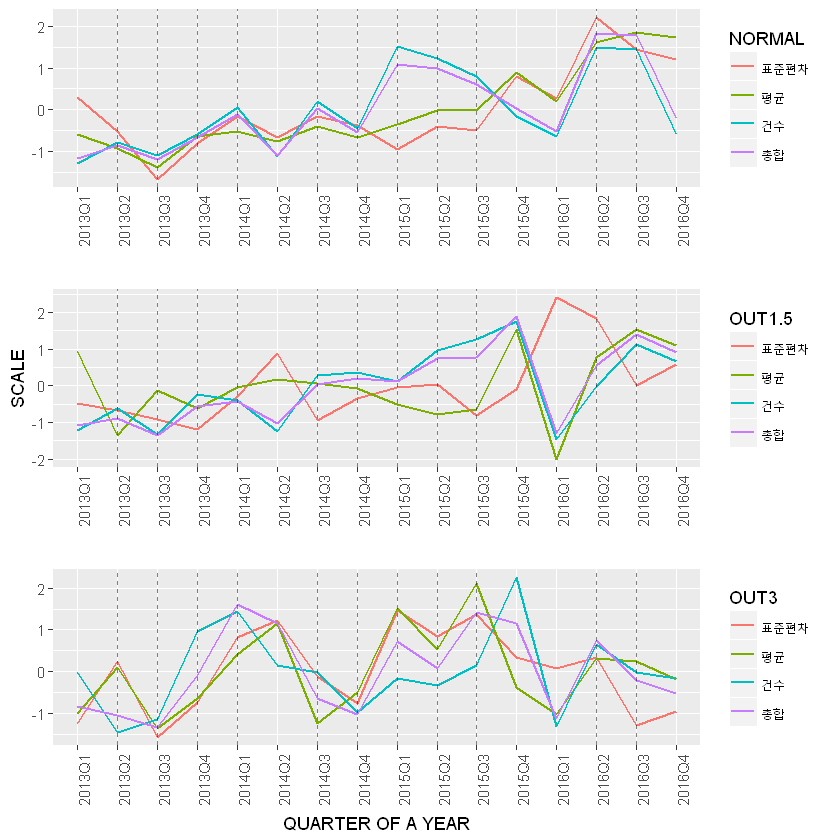

In [40]:
grid.arrange(p1, p2, p3, ncol=1)

- - -
**NORMAL, OUTLIER1.5 표준편차, 평균, 건수, 총합이 상승 추이를 그리고 있으며 계절성을 띄고 있다고 보기에는 힘들다.** 눈에 띄는 지점은 2016Q1시점으로 전체적으로 하양세를 그리고 있으나 **out1.5 분포의 표준편차는 상승하고 있다. 전체적인 분위기는 하양세이나 평균가가 높은 지역이나 단지들의 거래는 오히려 상승하지 않았을까 추측이 가능하다.** 조금 더 눈에 띄는 추이를 확인하기 위해 전분기 대비 증감률 그래프를 확인한다.
- - -

### ⊙각 분포, 분기별 [표준편차, 평균, 건수, 총합] 증감률 그래프⊙

In [41]:
normalb <- melt(normaltrade[[2]][order(분기)], id.vars = '분기', measure.vars = c(names(normaltrade[[2]])[c(7,8,10,11)]))
out1.5b <- melt(outtrade1.5[[2]][order(분기)], id.vars = '분기', measure.vars = c(names(outtrade1.5[[2]])[c(7,8,10,11)]))
out3b <- melt(outtrade3[[2]][order(분기)], id.vars = '분기', measure.vars = c(names(outtrade3[[2]])[c(7,8,10,11)]))


In [42]:
p1b <- ggplot(normalb,aes(x=분기, y=value, colour = variable,  group = variable)) +
  geom_line(size = .8) +
  theme(axis.text.x=element_text(angle=90))+
  geom_vline(xintercept = c(cn),linetype="dashed", alpha = .5) +
  labs(x='',y='') +
  guides(color=guide_legend(title="NORMAL"))
p2b <- ggplot(out1.5b,aes(x=분기, y=value, colour = variable,  group = variable)) +
  geom_line(size = .8) +
  theme(axis.text.x=element_text(angle=90))+
  geom_vline(xintercept = c(cn),linetype="dashed", alpha = .5)+
  labs(x = '',y='SCALE') +
  guides(color=guide_legend(title='OUT1.5'))
p3b <- ggplot(out3b,aes(x=분기, y=value, colour = variable,  group = variable)) +
  geom_line(size = .8) +
  theme(axis.text.x=element_text(angle=90))+
  geom_vline(xintercept = c(cn),linetype="dashed", alpha = .5)+
  labs(x='QUARTER OF A YEAR', y = '') +
  guides(color=guide_legend(title='OUT3'))

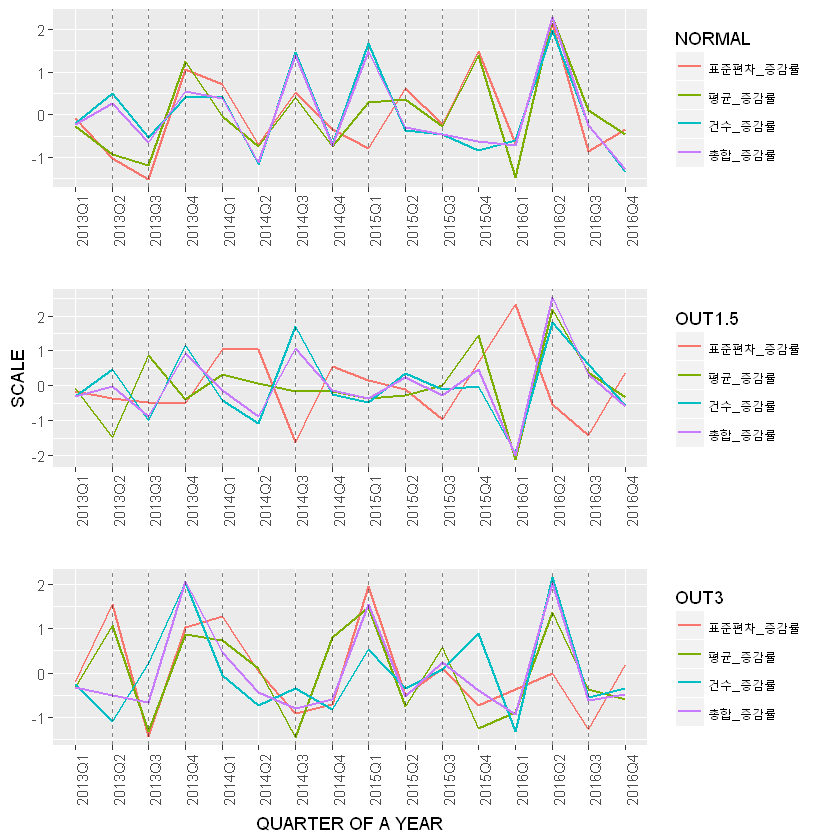

In [43]:
grid.arrange(p1b, p2b, p3b, ncol=1)

- - -
계절성 주기가 분기에 있다고 판단하기는 어렵다. **부동산 대책이 상승세이거나 하양세를 그릴때마다 있었며**  증감은 그에 어느정도 영향을 받고 있음이 확인 된다. 2014Q1 시점에 NORMA과 OUT1.5는 하락세이나 out3에서 큰폭의 증가가 있었고 이후 큰폭의 하락을 보인다.  **2015Q1시점에 건수와 총합, 평균은 상승하고 표준편차는 하락 한 것을 보면 전체적으로 고른 거래가 있었음을 확인 할 수 있다.**
- - -

### ⊙일반 거래와 증감률이 상반되는 분기 확인⊙
 그래프를 확인하면 normaltrade, outtrade1.5, outtrade3의 추이는 비슷한 형태를 그리지만 상반되는 시점들이 있다. 이를 확인 하여 당시의 뉴스기사 스크롤링을 통하여 상반되는 각 시점마다의 분위기를 확인하여 요인 파악한다.

In [44]:
a <- normaltrade[[1]][order(분기)][,8] > 0  
c <- normaltrade[[1]][order(분기)][,8] < 0

b <- outtrade1.5[[1]][order(분기)][,8] < 0
d <- outtrade1.5[[1]][order(분기)][,8] > 0

e <- outtrade3[[1]][order(분기)][,8] < 0
f <- outtrade3[[1]][order(분기)][,8] > 0

In [45]:
cat('NORMAL 상승 | OUT1.5 하락')
normaltrade[[1]][,1][which(as.logical(a==T & b==T))]
cat('NORMAL 하락 | OUT1.5 상승')
normaltrade[[1]][,1][which(as.logical(c==T & d==T))]
cat('---------------------------')
cat('\n\nNORMAL 상승 | OUT3 하락')
normaltrade[[1]][,1][which(as.logical(a==T & e==T))]
cat('NORMAL 하락 | OUT3 상승')
normaltrade[[1]][,1][which(as.logical(c==T & f==T))]

NORMAL 상승 | OUT1.5 하락

분기
2013Q4
2014Q3
2015Q1
2015Q2


NORMAL 하락 | OUT1.5 상승

분기
2013Q3
2014Q2


---------------------------

NORMAL 상승 | OUT3 하락

분기
2014Q3
2015Q2
2015Q4
2016Q3


NORMAL 하락 | OUT3 상승

분기
2013Q2
2014Q2
2014Q4


#### Save to MYSQL 

In [46]:
#mysql db에 data.table을 저장하는 함수 
#inputDt : 기술통계가 연산된 데이터 테이블
#dtname : database에 생성 할 테이블 이름

conMySQL <- function(inputDt, dtname){
  
  con <- dbConnect(MySQL(), user='root',password='1234', dbname = 'APT',
                   host='localhost', client.flag = CLIENT_MULTI_RESULTS)
  
  colnames(inputDt) <- c("quter",'sd','mean','med','n','sum','sd_per','mean_per','med_per','n_per','sum_per')
  
  
  query <- paste0("create table if not exists ", dtname, paste('(quter varchar(6)',
                                                                 'sd float(7,3)',
                                                                 'mean float(7,3)',
                                                                 'med float(7,3)',
                                                                 'n int(7)',
                                                                 'sum float(10,3)',
                                                                 'sd_per float(5,3)',
                                                                 'mean_per float(5,3)',
                                                                 'med_per float(5,3)',
                                                                 'n_per float(5,3)',
                                                                 'sum_per float(5,3))',sep = ','))
  dbGetQuery(con, query)
  dbWriteTable(con, dtname, inputDt, overwrite = F, row.names = FALSE, append = T, fileEncoding = 'UTF-8')
  dbDisconnect(con)
  
} 

In [47]:
conMySQL(normaltrade[[1]], "normalapt")
conMySQL(outtrade1.5[[1]], "outtrade1")
conMySQL(outtrade3[[1]], "outtrade3")

[1] TRUE

[1] TRUE

[1] TRUE

#### PS & Todo
- 부동산 거래 분석은 거래 추이에 영향이 있는 년도별, 분기별, 구별, 동별, 전용면적별, 층등 다양한 요인이 있다. 
  그 특성에 따른 분포 또한 다양하여 분포별로 나누거나, 데이터를 융합하고, 부동산 시장추이와 밀접한 관계에 있는   요인을 판별하여 분석을 할 필요가 있다.
- 찾아낸 분기 정보를 바탕으로 파이썬을 이용하여 우선적으로 기사 정보를 스크롤링 한다. 증감율이 분포마다 상반되   었을때 어떤 분위기가 형성되어있었으며 그 요인을 파악 할 수 있는지 시점의 차이에 따른 단어의 사용빈도를 확인     한다. 